In [1]:
#optional mount of google drive if files are not already in local directory/are using Google colab

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# load files from google drive  
!cp '/content/gdrive/My Drive/test_set.tar.gz' test_set.tar.gz
!cp '/content/gdrive/My Drive/train_set.tar.gz' train_set.tar.gz

#decompress files
!tar -xvf test_set.tar.gz
!tar -xvf train_set.tar.gz

In [1]:
#!pip install rasterio

import numpy as np
import torch
import torchvision
import torch.nn as nn
from torch.nn import BatchNorm2d
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import rasterio
import pandas as pd
import glob
import os

In [2]:
#get length of test and training set for later outputs
test_length = len(glob.glob('test_set/*.tif'))
train_length = len(glob.glob('train_set/*.tif'))

In [3]:
#connect to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.get_device_name(0)

cuda:0


'Tesla P100-PCIE-16GB'

In [4]:
class PingoDataset(Dataset):
  
  def __init__(self, images_dir, label_file = None):
    if label_file is not None:
        file_name = images_dir + '/' + label_file
        df = pd.read_csv(file_name)
        self.labels = df['label']
        self.file = df['file name']
    self.img_dir = images_dir 

  def __len__(self):
    return len(glob.glob1(self.img_dir, '*.tif')) -1

  def __getitem__(self, idx):
    label = self.labels[idx]
    label = torch.tensor(label)
    label = label.type(torch.LongTensor)
    image_path = self.img_dir + '/' + self.file[idx]
    src = rasterio.open(image_path)
    image = src.read()
    image[image < 0] = 0
    image = torch.from_numpy(image)
    #normalize data
    mean, std = image.mean([1,2]), image.std([1,2])
    for i, num in enumerate(std):
     if num == 0:
       std[i] = 1e-10
    transform_norm = transforms.Normalize(mean,std)
    image = transform_norm(image)

    return image, label

In [5]:
train_data = PingoDataset('train_set','train.csv')
test_data = PingoDataset('test_set','test.csv')

[[-7.4393163  -7.4393163  -7.4393163  ... -7.4393163  -7.4393163
  -7.4393163 ]
 [-1.9164064  -1.9164064  -1.9164064  ...  0.6853859   0.66229033
   0.616601  ]
 [-1.9164064  -1.9164064  -1.9164064  ...  0.653253    0.616601
   0.57593215]
 ...
 [-0.21083121 -0.21083121 -0.20681484 ... -1.4143237  -1.4143237
  -1.4143237 ]
 [-0.18120833 -0.18120833 -0.18120833 ... -1.4143237  -1.4143237
  -1.4143237 ]
 [-0.18120833 -0.18120833 -0.17719196 ... -1.4143237  -1.4143237
  -1.4143237 ]]


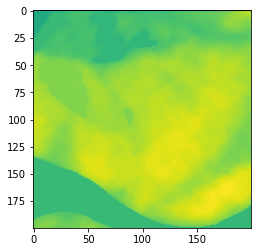

In [6]:
#plot sample image and print values to confirm that 
#dataset and normalization are correct

data_point = train_data[1110]
image = data_point[0]
image = image[0,:,:].numpy()
plt.imshow(image)
print(image)

In [7]:
model = torch.nn.Sequential(nn.Conv2d(in_channels=4, out_channels=64 , kernel_size=3, padding=0),
                            BatchNorm2d(64),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2),
                            nn.Conv2d(in_channels=64, out_channels=64 , kernel_size=3, padding=0),
                            BatchNorm2d(64),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2),
                            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0),
                            BatchNorm2d(128),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2),
                            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=0),
                            BatchNorm2d(128),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2),
                            nn.Flatten(),
                            nn.Linear(12800,80),
                            nn.ReLU(), 
                            nn.Linear(80,1),
                            nn.Sigmoid())

In [ ]:
#print model output shapes

X = torch.rand(size=(1, 4, 200, 200), dtype=torch.float32)
print('Initial input shape: \t', X.shape)
for layer in model:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

In [9]:
def train(model, n_epochs, lr, device, test_length, batch_size, trainloader, testloader=None):

    # Save loss and accuracy for plotting
    loss_time = np.zeros(n_epochs)
    accuracy_time = np.zeros(n_epochs)
    predictions = np.full((n_epochs,test_length),5)

    # Initialize weights
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    model.apply(init_weights)
    model.to(device)

    # Define loss and optimization method
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss = nn.BCELoss()

    # Loop on number of epochs
    for epoch in range(n_epochs):
        # Initialize the loss
        running_loss = 0
        model.train()
        # Loop on samples in train set
        for i, (X, y) in enumerate(trainloader):
            X = X.float()
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            y=y.unsqueeze(1)
            l = loss(y_hat, y.float())
            l.backward()
            optimizer.step()
            # Add the value of the loss for this sample
            running_loss += l.item()
        # Save loss at the end of each epoch
        loss_time[epoch] = running_loss / len(trainloader)
        # After each epoch, evaluate the performance on the test set
        if testloader is not None:
            correct = 0
            total = 0
            # We evaluate the model, so we do not need the gradient
            with torch.no_grad():
                # Loop on samples in test set
                for i, (X, y) in enumerate(testloader):
                    X = X.float()
                    X, y = X.to(device), y.to(device)
                    y_hat = model(X)
                    # Compare predicted label and true label
                    predicted = torch.round(y_hat)
                    total += y.size(0)
                    correct += (predicted[0] == y).sum().item()
                    print((predicted[0] == y).sum().item())
                    if len(predicted) == batch_size:
                      predictions[epoch,i*batch_size:(i+1)*batch_size]=predicted[0].cpu()
                    else: 
                      predictions[epoch,i*batch_size:]=predicted[0].cpu()
            # Save accuracy at the end of each epochs
            accuracy_time[epoch] = 100 * correct / total
    
        # Print intermediate results on screen
        if testloader is not None:
            print('[Epoch %d] loss: %.3f - accuracy: %.3f' %
              (epoch + 1, running_loss, 100 * correct / total))
        else:
            print('[Epoch %d] loss: %.3f' %
              (epoch + 1, running_loss / len(trainloader)))

    # Save history of loss and test accuracy
    if testloader is not None:
        return (loss_time, accuracy_time, predictions,y)
    else:
        return (loss_time)

In [10]:
train_dataloader = DataLoader(train_data, batch_size=200)
test_dataloader = DataLoader(test_data, batch_size=200)

In [ ]:
(loss, accuracy, predicted, y) = train(model, 10, 0.0001, device, test_length-1, 200, train_dataloader, test_dataloader)

In [ ]:
#Optional testing with kfolf cross-validation

from sklearn.model_selection import KFold

dataset = ConcatDataset([train_data, test_data])

kfold = KFold(n_splits=5,shuffle=True)

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

  print(f'FOLD {fold}')
  print('--------------------------------')

  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

  trainloader = DataLoader(dataset,batch_size=256, sampler=train_subsampler)
  testloader = DataLoader(dataset, batch_size=256, sampler=test_subsampler)

  (loss, accuracy, predicted, y) = train(model, 10, 0.01, device, test_length-1, 256, train_dataloader, test_dataloader)